## SET UP

In [23]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
from scipy.stats import boxcox
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [24]:
plt.style.use('bmh')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.float_Format', '{:,.2f}'.format)
np.set_printoptions(suppress=True)

## DATA UPLOAD

In [25]:
_path = 'ILL_KPI.xlsx'
df = pd.read_excel(_path)

df.head()

,ORG_STATE,DISTRICT_ID,DISTRICT,DISTRICT_STATUS,SCHOOL_ID,SCHOOL,SCHOOL_STATUS,SITE_KEY,SCHOOL_YEAR,SCHOOL_ENROLLED_STUDENTS,DISTRICT_ENROLLED_STUDENTS,SCHOOL_LOGINS,DISTRICT_LOGINS,SCHOOL_UNI_LOGINS,DISTRICT_UNI_LOGINS,SCHOOL_UNI_STUDENT_LOGIN,DISTRICT_UNI_STUDENT_LOGIN,SCHOOL_UNI_EDUCATOR_LOGIN,DISTRICT_UNI_EDUCATOR_LOGIN,SCHOOL_UNI_ADMIN_LOGIN,DISTRICT_UNI_ADMIN_LOGIN,SCHOOL_TOTAL_LESSONS,SCHOOL_UNIQUE_LESSONS,DISTRICT_TOTAL_LESSONS,DISTRICT_UNIQUE_LESSONS,SCHOOL_AVERAGE_MINUTES_SPENT,DISTRICT_AVERAGE_MINUTES_SPENT,SCHOOL_ACHIEVEMENT_PERCENTAGE,DISTRICT_ACHIEVEMENT_PERCENTAGE,SCHOOL_PASS_PERCENTAGE,DISTRICT_PASS_PERCENTAGE,ILL_BOY_TO_MOY_GROWTH_SCHOOL,ILL_MOY_TO_EOY_GROWTH_SCHOOL,ILL_BOY_TO_MOY_GROWTH_DISTRICT,ILL_MOY_TO_EOY_GROWTH_DISTRICT
0,TX,3642113,Austin ISD,Active,3541137,Mills Elementary,Active,4808940,2022-23,195,221,4970,8400,195,221,195,221,0,0,0,0,16735,354,15314,339,"1,104.63","1,856.50",0.98,0.98,0.18,0.17,[NULL],[NULL],[NULL],[NULL]
1,MA,3640392,Worcester Public Schools,Active,3640495,May Street,Active,2513230,2022-23,23,78,1412,3515,23,78,23,78,0,0,0,0,1723,241,4100,233,254.48,618.76,0.98,0.96,0.21,0.17,11.35,-3.20,2.06,4.05
2,NY,3517655,Queens - District 25,Active,3522686,25Q120 - PS 120 Queens,Active,3600122,2022-23,[NULL],[NULL],[NULL],[NULL],[NULL],[NULL],[NULL],[NULL],[NULL],[NULL],[NULL],[NULL],67508,385,9894,236,[NULL],[NULL],0.99,0.96,0.08,0.18,-64.01,64.47,2.89,7.57
3,TX,3554174,Midland ISD,Active,3554027,LONG ELEMENTARY,Active,4830570,2021-22,188,71,25166,10065,188,71,188,71,0,0,0,0,105383,385,99771,354,"4,485.81","1,811.29",0.99,1.00,0.16,0.17,57.71,-57.71,63.54,-60.64
4,CA,3582778,Moreno Valley Unified School District (CA),Active,3582927,Creekside Elementary,Active,625800,2021-22,207,170,15910,13586,207,170,207,170,0,0,0,0,40451,267,47860,359,"2,957.44","2,692.41",0.98,1.00,0.16,0.11,56.57,-1.75,57.99,-1.94


In [26]:
df.shape

(64716, 35)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64716 entries, 0 to 64715
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   ORG_STATE                        62152 non-null  object
 1   DISTRICT_ID                      64716 non-null  int64 
 2   DISTRICT                         64716 non-null  object
 3   DISTRICT_STATUS                  64716 non-null  object
 4   SCHOOL_ID                        64716 non-null  int64 
 5   SCHOOL                           64716 non-null  object
 6   SCHOOL_STATUS                    64716 non-null  object
 7   SITE_KEY                         64716 non-null  object
 8   SCHOOL_YEAR                      64716 non-null  object
 9   SCHOOL_ENROLLED_STUDENTS         64716 non-null  object
 10  DISTRICT_ENROLLED_STUDENTS       64716 non-null  object
 11  SCHOOL_LOGINS                    64716 non-null  object
 12  DISTRICT_LOGINS                 

In [28]:
df.replace('[NULL]', np.nan, inplace=True)
df.head()

,ORG_STATE,DISTRICT_ID,DISTRICT,DISTRICT_STATUS,SCHOOL_ID,SCHOOL,SCHOOL_STATUS,SITE_KEY,SCHOOL_YEAR,SCHOOL_ENROLLED_STUDENTS,DISTRICT_ENROLLED_STUDENTS,SCHOOL_LOGINS,DISTRICT_LOGINS,SCHOOL_UNI_LOGINS,DISTRICT_UNI_LOGINS,SCHOOL_UNI_STUDENT_LOGIN,DISTRICT_UNI_STUDENT_LOGIN,SCHOOL_UNI_EDUCATOR_LOGIN,DISTRICT_UNI_EDUCATOR_LOGIN,SCHOOL_UNI_ADMIN_LOGIN,DISTRICT_UNI_ADMIN_LOGIN,SCHOOL_TOTAL_LESSONS,SCHOOL_UNIQUE_LESSONS,DISTRICT_TOTAL_LESSONS,DISTRICT_UNIQUE_LESSONS,SCHOOL_AVERAGE_MINUTES_SPENT,DISTRICT_AVERAGE_MINUTES_SPENT,SCHOOL_ACHIEVEMENT_PERCENTAGE,DISTRICT_ACHIEVEMENT_PERCENTAGE,SCHOOL_PASS_PERCENTAGE,DISTRICT_PASS_PERCENTAGE,ILL_BOY_TO_MOY_GROWTH_SCHOOL,ILL_MOY_TO_EOY_GROWTH_SCHOOL,ILL_BOY_TO_MOY_GROWTH_DISTRICT,ILL_MOY_TO_EOY_GROWTH_DISTRICT
0,TX,3642113,Austin ISD,Active,3541137,Mills Elementary,Active,4808940,2022-23,195.00,221.00,"4,970.00","8,400.00",195.00,221.00,195.00,221.00,0.00,0.00,0.00,0.00,"16,735.00",354.00,"15,314.00",339.00,"1,104.63","1,856.50",0.98,0.98,0.18,0.17,NaN,NaN,NaN,NaN
1,MA,3640392,Worcester Public Schools,Active,3640495,May Street,Active,2513230,2022-23,23.00,78.00,"1,412.00","3,515.00",23.00,78.00,23.00,78.00,0.00,0.00,0.00,0.00,"1,723.00",241.00,"4,100.00",233.00,254.48,618.76,0.98,0.96,0.21,0.17,11.35,-3.20,2.06,4.05
2,NY,3517655,Queens - District 25,Active,3522686,25Q120 - PS 120 Queens,Active,3600122,2022-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"67,508.00",385.00,"9,894.00",236.00,NaN,NaN,0.99,0.96,0.08,0.18,-64.01,64.47,2.89,7.57
3,TX,3554174,Midland ISD,Active,3554027,LONG ELEMENTARY,Active,4830570,2021-22,188.00,71.00,"25,166.00","10,065.00",188.00,71.00,188.00,71.00,0.00,0.00,0.00,0.00,"105,383.00",385.00,"99,771.00",354.00,"4,485.81","1,811.29",0.99,1.00,0.16,0.17,57.71,-57.71,63.54,-60.64
4,CA,3582778,Moreno Valley Unified School District (CA),Active,3582927,Creekside Elementary,Active,625800,2021-22,207.00,170.00,"15,910.00","13,586.00",207.00,170.00,207.00,170.00,0.00,0.00,0.00,0.00,"40,451.00",267.00,"47,860.00",359.00,"2,957.44","2,692.41",0.98,1.00,0.16,0.11,56.57,-1.75,57.99,-1.94


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64716 entries, 0 to 64715
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ORG_STATE                        62152 non-null  object 
 1   DISTRICT_ID                      64716 non-null  int64  
 2   DISTRICT                         64716 non-null  object 
 3   DISTRICT_STATUS                  64716 non-null  object 
 4   SCHOOL_ID                        64716 non-null  int64  
 5   SCHOOL                           64716 non-null  object 
 6   SCHOOL_STATUS                    64716 non-null  object 
 7   SITE_KEY                         63586 non-null  object 
 8   SCHOOL_YEAR                      64716 non-null  object 
 9   SCHOOL_ENROLLED_STUDENTS         44799 non-null  float64
 10  DISTRICT_ENROLLED_STUDENTS       44799 non-null  float64
 11  SCHOOL_LOGINS                    44799 non-null  float64
 12  DISTRICT_LOGINS   

In [30]:
org_index = df[['ORG_STATE', 'DISTRICT_ID', 'DISTRICT', 'DISTRICT_STATUS', 'SCHOOL_ID', 'SCHOOL', 'SITE_KEY']]

In [31]:
churn_metrics = df.iloc[:, 8:35]
churn_metrics.loc[:, 'is_churn'] = df['SCHOOL_STATUS']
churn_metrics.head()

,SCHOOL_YEAR,SCHOOL_ENROLLED_STUDENTS,DISTRICT_ENROLLED_STUDENTS,SCHOOL_LOGINS,DISTRICT_LOGINS,SCHOOL_UNI_LOGINS,DISTRICT_UNI_LOGINS,SCHOOL_UNI_STUDENT_LOGIN,DISTRICT_UNI_STUDENT_LOGIN,SCHOOL_UNI_EDUCATOR_LOGIN,DISTRICT_UNI_EDUCATOR_LOGIN,SCHOOL_UNI_ADMIN_LOGIN,DISTRICT_UNI_ADMIN_LOGIN,SCHOOL_TOTAL_LESSONS,SCHOOL_UNIQUE_LESSONS,DISTRICT_TOTAL_LESSONS,DISTRICT_UNIQUE_LESSONS,SCHOOL_AVERAGE_MINUTES_SPENT,DISTRICT_AVERAGE_MINUTES_SPENT,SCHOOL_ACHIEVEMENT_PERCENTAGE,DISTRICT_ACHIEVEMENT_PERCENTAGE,SCHOOL_PASS_PERCENTAGE,DISTRICT_PASS_PERCENTAGE,ILL_BOY_TO_MOY_GROWTH_SCHOOL,ILL_MOY_TO_EOY_GROWTH_SCHOOL,ILL_BOY_TO_MOY_GROWTH_DISTRICT,ILL_MOY_TO_EOY_GROWTH_DISTRICT,is_churn
0,2022-23,195.00,221.00,"4,970.00","8,400.00",195.00,221.00,195.00,221.00,0.00,0.00,0.00,0.00,"16,735.00",354.00,"15,314.00",339.00,"1,104.63","1,856.50",0.98,0.98,0.18,0.17,NaN,NaN,NaN,NaN,Active
1,2022-23,23.00,78.00,"1,412.00","3,515.00",23.00,78.00,23.00,78.00,0.00,0.00,0.00,0.00,"1,723.00",241.00,"4,100.00",233.00,254.48,618.76,0.98,0.96,0.21,0.17,11.35,-3.20,2.06,4.05,Active
2,2022-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"67,508.00",385.00,"9,894.00",236.00,NaN,NaN,0.99,0.96,0.08,0.18,-64.01,64.47,2.89,7.57,Active
3,2021-22,188.00,71.00,"25,166.00","10,065.00",188.00,71.00,188.00,71.00,0.00,0.00,0.00,0.00,"105,383.00",385.00,"99,771.00",354.00,"4,485.81","1,811.29",0.99,1.00,0.16,0.17,57.71,-57.71,63.54,-60.64,Active
4,2021-22,207.00,170.00,"15,910.00","13,586.00",207.00,170.00,207.00,170.00,0.00,0.00,0.00,0.00,"40,451.00",267.00,"47,860.00",359.00,"2,957.44","2,692.41",0.98,1.00,0.16,0.11,56.57,-1.75,57.99,-1.94,Active


In [32]:
churn_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64716 entries, 0 to 64715
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SCHOOL_YEAR                      64716 non-null  object 
 1   SCHOOL_ENROLLED_STUDENTS         44799 non-null  float64
 2   DISTRICT_ENROLLED_STUDENTS       44799 non-null  float64
 3   SCHOOL_LOGINS                    44799 non-null  float64
 4   DISTRICT_LOGINS                  44799 non-null  float64
 5   SCHOOL_UNI_LOGINS                44799 non-null  float64
 6   DISTRICT_UNI_LOGINS              44799 non-null  float64
 7   SCHOOL_UNI_STUDENT_LOGIN         44799 non-null  float64
 8   DISTRICT_UNI_STUDENT_LOGIN       44799 non-null  float64
 9   SCHOOL_UNI_EDUCATOR_LOGIN        44799 non-null  float64
 10  DISTRICT_UNI_EDUCATOR_LOGIN      44799 non-null  float64
 11  SCHOOL_UNI_ADMIN_LOGIN           44799 non-null  float64
 12  DISTRICT_UNI_ADMIN

In [33]:
churn_metrics.dropna(subset='is_churn', inplace=True)

In [34]:
churn_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64716 entries, 0 to 64715
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SCHOOL_YEAR                      64716 non-null  object 
 1   SCHOOL_ENROLLED_STUDENTS         44799 non-null  float64
 2   DISTRICT_ENROLLED_STUDENTS       44799 non-null  float64
 3   SCHOOL_LOGINS                    44799 non-null  float64
 4   DISTRICT_LOGINS                  44799 non-null  float64
 5   SCHOOL_UNI_LOGINS                44799 non-null  float64
 6   DISTRICT_UNI_LOGINS              44799 non-null  float64
 7   SCHOOL_UNI_STUDENT_LOGIN         44799 non-null  float64
 8   DISTRICT_UNI_STUDENT_LOGIN       44799 non-null  float64
 9   SCHOOL_UNI_EDUCATOR_LOGIN        44799 non-null  float64
 10  DISTRICT_UNI_EDUCATOR_LOGIN      44799 non-null  float64
 11  SCHOOL_UNI_ADMIN_LOGIN           44799 non-null  float64
 12  DISTRICT_UNI_ADMIN

In [35]:
churn_metrics.fillna(0, inplace=True)

In [36]:
churn_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64716 entries, 0 to 64715
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SCHOOL_YEAR                      64716 non-null  object 
 1   SCHOOL_ENROLLED_STUDENTS         64716 non-null  float64
 2   DISTRICT_ENROLLED_STUDENTS       64716 non-null  float64
 3   SCHOOL_LOGINS                    64716 non-null  float64
 4   DISTRICT_LOGINS                  64716 non-null  float64
 5   SCHOOL_UNI_LOGINS                64716 non-null  float64
 6   DISTRICT_UNI_LOGINS              64716 non-null  float64
 7   SCHOOL_UNI_STUDENT_LOGIN         64716 non-null  float64
 8   DISTRICT_UNI_STUDENT_LOGIN       64716 non-null  float64
 9   SCHOOL_UNI_EDUCATOR_LOGIN        64716 non-null  float64
 10  DISTRICT_UNI_EDUCATOR_LOGIN      64716 non-null  float64
 11  SCHOOL_UNI_ADMIN_LOGIN           64716 non-null  float64
 12  DISTRICT_UNI_ADMIN

In [37]:
churn_metrics = churn_metrics.astype({'SCHOOL_ENROLLED_STUDENTS':'int',
'DISTRICT_ENROLLED_STUDENTS':'int',
'SCHOOL_LOGINS':'int',
'DISTRICT_LOGINS':'int',
'SCHOOL_UNI_LOGINS':'int',
'DISTRICT_UNI_LOGINS':'int',
'SCHOOL_UNI_STUDENT_LOGIN':'int',
'DISTRICT_UNI_STUDENT_LOGIN':'int',
'SCHOOL_UNI_EDUCATOR_LOGIN':'int',
'DISTRICT_UNI_EDUCATOR_LOGIN':'int',
'SCHOOL_UNI_ADMIN_LOGIN':'int',
'DISTRICT_UNI_ADMIN_LOGIN':'int',
'SCHOOL_TOTAL_LESSONS':'int',
'SCHOOL_UNIQUE_LESSONS':'int',
'DISTRICT_TOTAL_LESSONS':'int',
'DISTRICT_UNIQUE_LESSONS':'int',
'SCHOOL_AVERAGE_MINUTES_SPENT':'int',
'DISTRICT_AVERAGE_MINUTES_SPENT':'int'})

In [38]:
churn_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64716 entries, 0 to 64715
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SCHOOL_YEAR                      64716 non-null  object 
 1   SCHOOL_ENROLLED_STUDENTS         64716 non-null  int64  
 2   DISTRICT_ENROLLED_STUDENTS       64716 non-null  int64  
 3   SCHOOL_LOGINS                    64716 non-null  int64  
 4   DISTRICT_LOGINS                  64716 non-null  int64  
 5   SCHOOL_UNI_LOGINS                64716 non-null  int64  
 6   DISTRICT_UNI_LOGINS              64716 non-null  int64  
 7   SCHOOL_UNI_STUDENT_LOGIN         64716 non-null  int64  
 8   DISTRICT_UNI_STUDENT_LOGIN       64716 non-null  int64  
 9   SCHOOL_UNI_EDUCATOR_LOGIN        64716 non-null  int64  
 10  DISTRICT_UNI_EDUCATOR_LOGIN      64716 non-null  int64  
 11  SCHOOL_UNI_ADMIN_LOGIN           64716 non-null  int64  
 12  DISTRICT_UNI_ADMIN

In [39]:
churn_metrics.describe(include='all')

,SCHOOL_YEAR,SCHOOL_ENROLLED_STUDENTS,DISTRICT_ENROLLED_STUDENTS,SCHOOL_LOGINS,DISTRICT_LOGINS,SCHOOL_UNI_LOGINS,DISTRICT_UNI_LOGINS,SCHOOL_UNI_STUDENT_LOGIN,DISTRICT_UNI_STUDENT_LOGIN,SCHOOL_UNI_EDUCATOR_LOGIN,DISTRICT_UNI_EDUCATOR_LOGIN,SCHOOL_UNI_ADMIN_LOGIN,DISTRICT_UNI_ADMIN_LOGIN,SCHOOL_TOTAL_LESSONS,SCHOOL_UNIQUE_LESSONS,DISTRICT_TOTAL_LESSONS,DISTRICT_UNIQUE_LESSONS,SCHOOL_AVERAGE_MINUTES_SPENT,DISTRICT_AVERAGE_MINUTES_SPENT,SCHOOL_ACHIEVEMENT_PERCENTAGE,DISTRICT_ACHIEVEMENT_PERCENTAGE,SCHOOL_PASS_PERCENTAGE,DISTRICT_PASS_PERCENTAGE,ILL_BOY_TO_MOY_GROWTH_SCHOOL,ILL_MOY_TO_EOY_GROWTH_SCHOOL,ILL_BOY_TO_MOY_GROWTH_DISTRICT,ILL_MOY_TO_EOY_GROWTH_DISTRICT,is_churn
count,64716,"64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00",64716
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,2021-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active
freq,18562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63463
mean,NaN,48.83,48.83,"2,684.37","2,684.38",48.83,48.83,48.83,48.83,0.00,0.00,0.00,0.00,"7,218.20",216.60,"7,218.20",216.60,532.36,532.34,0.80,0.80,0.26,0.26,5.57,-5.92,5.57,-5.92,NaN
std,NaN,117.39,90.78,"8,498.32","6,480.04",117.39,90.78,117.39,90.78,0.00,0.00,0.00,0.00,"18,769.27",121.72,"14,634.67",97.13,"1,658.66","1,264.38",0.35,0.34,0.31,0.30,28.35,27.71,21.20,22.74,NaN
min,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-100.00,-100.00,-100.00,-100.00,NaN
25%,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,245.00,121.00,731.00,158.00,0.00,0.00,0.91,0.90,0.05,0.09,-3.57,-6.18,-1.42,-4.71,NaN
50%,NaN,5.00,12.00,137.00,407.00,5.00,12.00,5.00,12.00,0.00,0.00,0.00,0.00,"1,386.00",229.00,"2,413.00",229.00,28.00,86.00,0.97,0.96,0.15,0.16,0.00,0.00,0.00,0.00,NaN
75%,NaN,37.00,49.25,"1,345.00","2,115.00",37.00,49.25,37.00,49.25,0.00,0.00,0.00,0.00,"5,550.00",321.00,"6,628.00",287.00,280.00,448.00,0.99,0.98,0.30,0.26,6.17,2.47,9.05,2.53,NaN


In [40]:
churn_metrics['is_churn'] = churn_metrics['is_churn'].map({'Inactive': 1, 'Active': 0})

In [58]:
churn_metrics['is_churn'].sum()/churn_metrics.shape[0]

0.019361518017182767

In [41]:
churn_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64716 entries, 0 to 64715
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SCHOOL_YEAR                      64716 non-null  object 
 1   SCHOOL_ENROLLED_STUDENTS         64716 non-null  int64  
 2   DISTRICT_ENROLLED_STUDENTS       64716 non-null  int64  
 3   SCHOOL_LOGINS                    64716 non-null  int64  
 4   DISTRICT_LOGINS                  64716 non-null  int64  
 5   SCHOOL_UNI_LOGINS                64716 non-null  int64  
 6   DISTRICT_UNI_LOGINS              64716 non-null  int64  
 7   SCHOOL_UNI_STUDENT_LOGIN         64716 non-null  int64  
 8   DISTRICT_UNI_STUDENT_LOGIN       64716 non-null  int64  
 9   SCHOOL_UNI_EDUCATOR_LOGIN        64716 non-null  int64  
 10  DISTRICT_UNI_EDUCATOR_LOGIN      64716 non-null  int64  
 11  SCHOOL_UNI_ADMIN_LOGIN           64716 non-null  int64  
 12  DISTRICT_UNI_ADMIN

In [42]:
churn_metrics.describe(include='all')

,SCHOOL_YEAR,SCHOOL_ENROLLED_STUDENTS,DISTRICT_ENROLLED_STUDENTS,SCHOOL_LOGINS,DISTRICT_LOGINS,SCHOOL_UNI_LOGINS,DISTRICT_UNI_LOGINS,SCHOOL_UNI_STUDENT_LOGIN,DISTRICT_UNI_STUDENT_LOGIN,SCHOOL_UNI_EDUCATOR_LOGIN,DISTRICT_UNI_EDUCATOR_LOGIN,SCHOOL_UNI_ADMIN_LOGIN,DISTRICT_UNI_ADMIN_LOGIN,SCHOOL_TOTAL_LESSONS,SCHOOL_UNIQUE_LESSONS,DISTRICT_TOTAL_LESSONS,DISTRICT_UNIQUE_LESSONS,SCHOOL_AVERAGE_MINUTES_SPENT,DISTRICT_AVERAGE_MINUTES_SPENT,SCHOOL_ACHIEVEMENT_PERCENTAGE,DISTRICT_ACHIEVEMENT_PERCENTAGE,SCHOOL_PASS_PERCENTAGE,DISTRICT_PASS_PERCENTAGE,ILL_BOY_TO_MOY_GROWTH_SCHOOL,ILL_MOY_TO_EOY_GROWTH_SCHOOL,ILL_BOY_TO_MOY_GROWTH_DISTRICT,ILL_MOY_TO_EOY_GROWTH_DISTRICT,is_churn
count,64716,"64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00","64,716.00"
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2021-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,18562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,48.83,48.83,"2,684.37","2,684.38",48.83,48.83,48.83,48.83,0.00,0.00,0.00,0.00,"7,218.20",216.60,"7,218.20",216.60,532.36,532.34,0.80,0.80,0.26,0.26,5.57,-5.92,5.57,-5.92,0.02
std,NaN,117.39,90.78,"8,498.32","6,480.04",117.39,90.78,117.39,90.78,0.00,0.00,0.00,0.00,"18,769.27",121.72,"14,634.67",97.13,"1,658.66","1,264.38",0.35,0.34,0.31,0.30,28.35,27.71,21.20,22.74,0.14
min,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-100.00,-100.00,-100.00,-100.00,0.00
25%,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,245.00,121.00,731.00,158.00,0.00,0.00,0.91,0.90,0.05,0.09,-3.57,-6.18,-1.42,-4.71,0.00
50%,NaN,5.00,12.00,137.00,407.00,5.00,12.00,5.00,12.00,0.00,0.00,0.00,0.00,"1,386.00",229.00,"2,413.00",229.00,28.00,86.00,0.97,0.96,0.15,0.16,0.00,0.00,0.00,0.00,0.00
75%,NaN,37.00,49.25,"1,345.00","2,115.00",37.00,49.25,37.00,49.25,0.00,0.00,0.00,0.00,"5,550.00",321.00,"6,628.00",287.00,280.00,448.00,0.99,0.98,0.30,0.26,6.17,2.47,9.05,2.53,0.00


## COHORT ANALYSIS

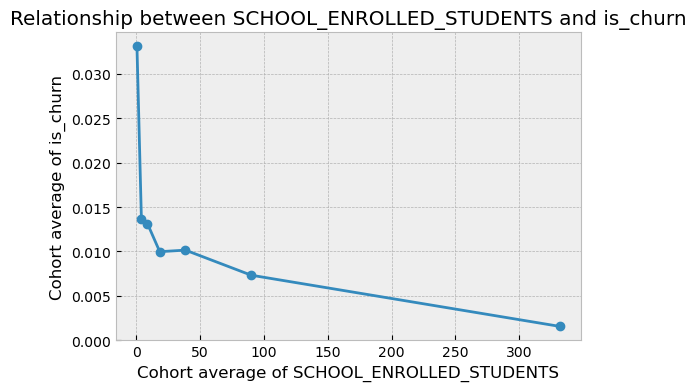

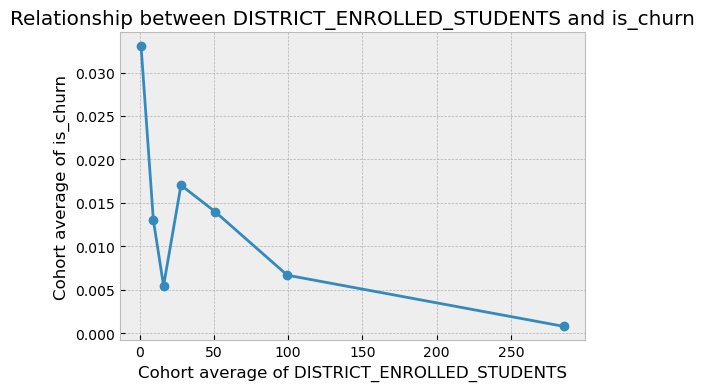

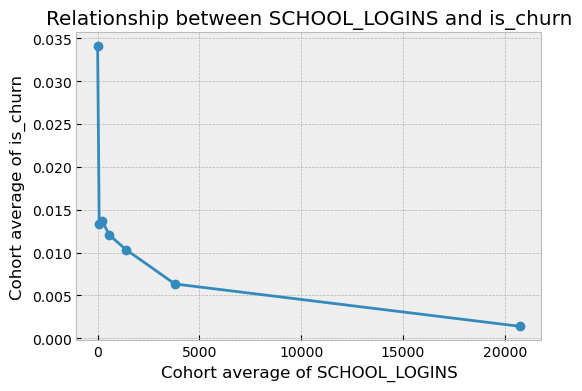

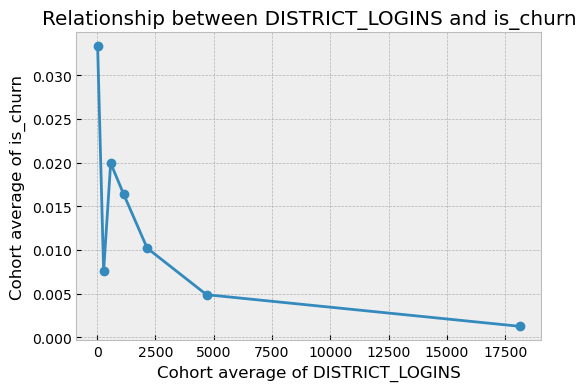

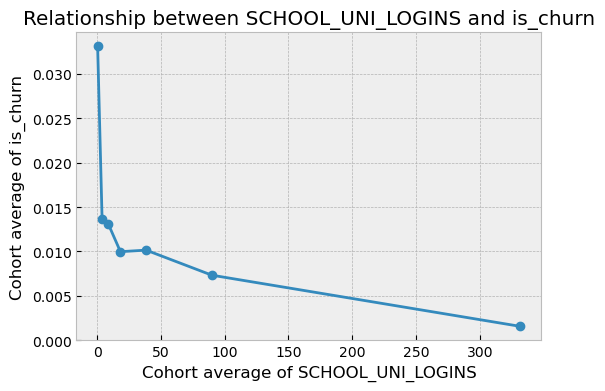

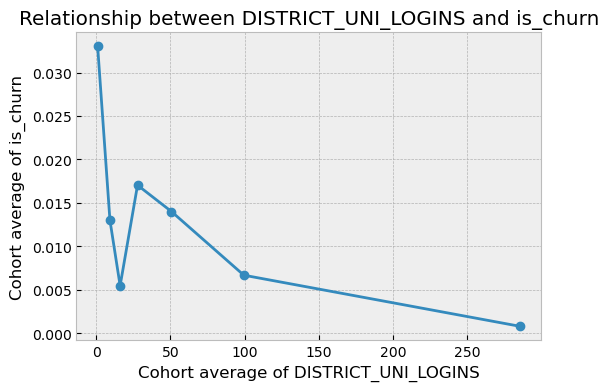

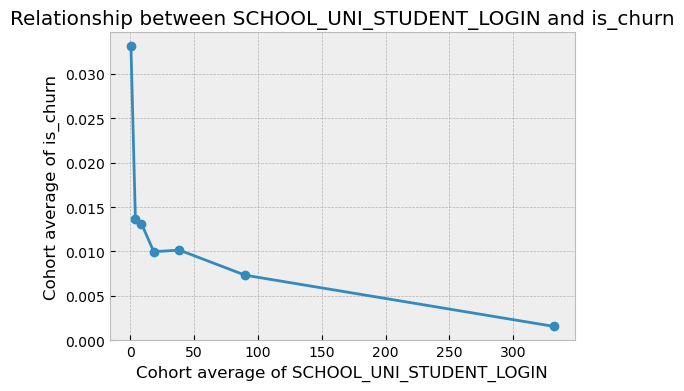

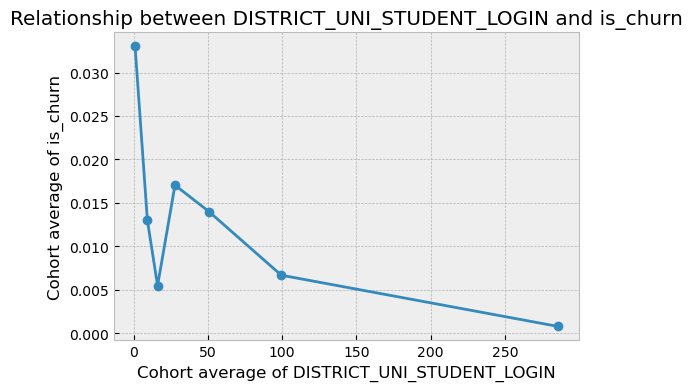

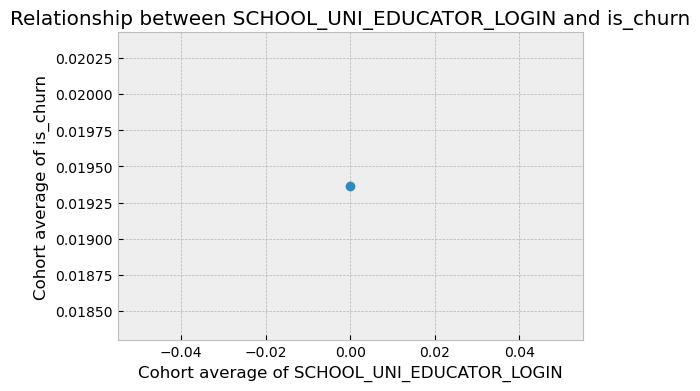

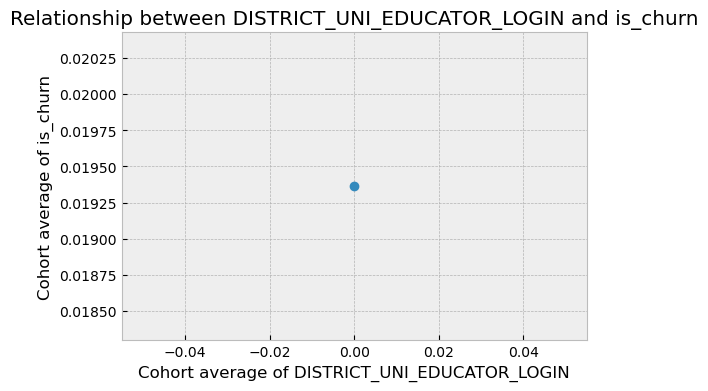

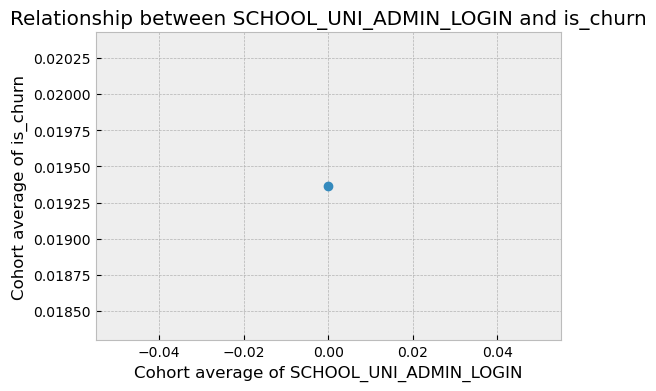

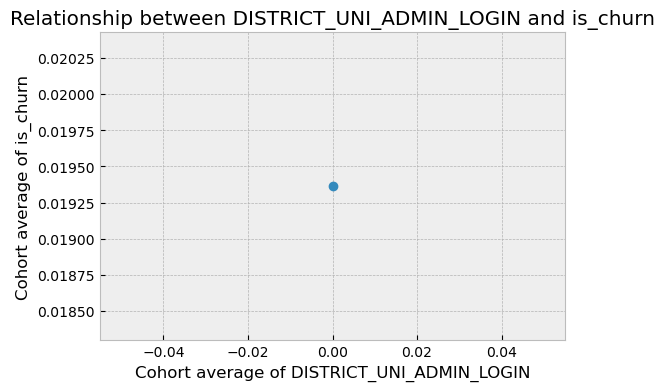

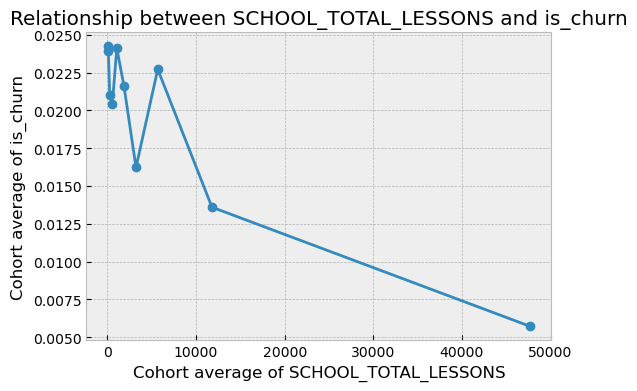

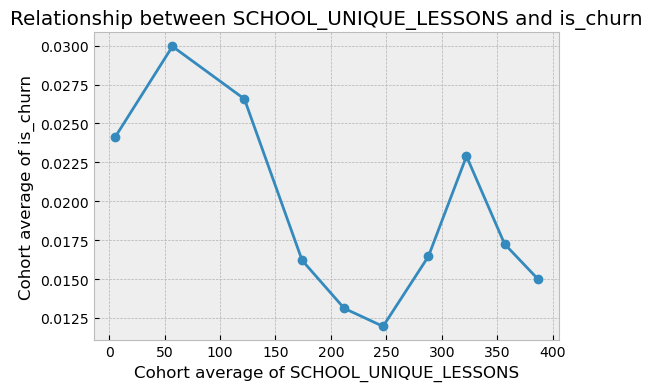

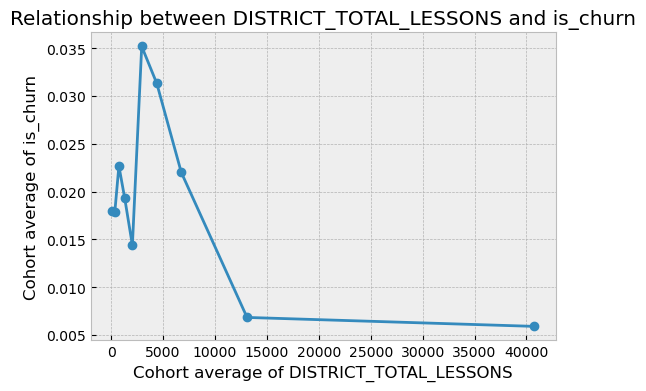

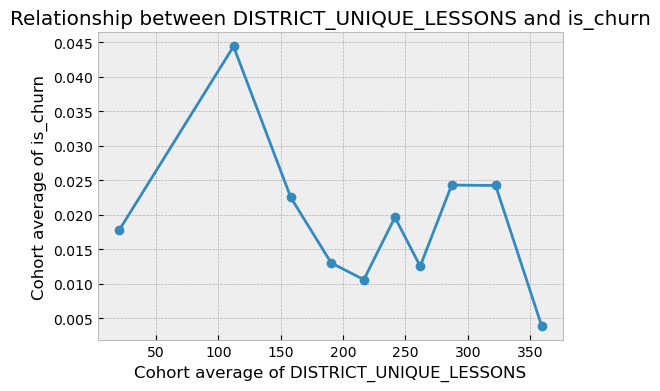

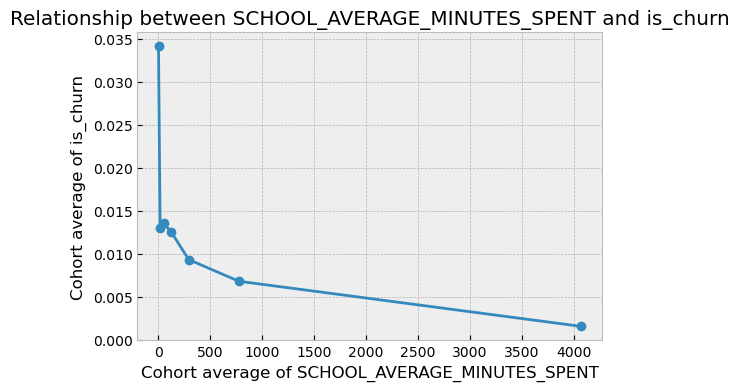

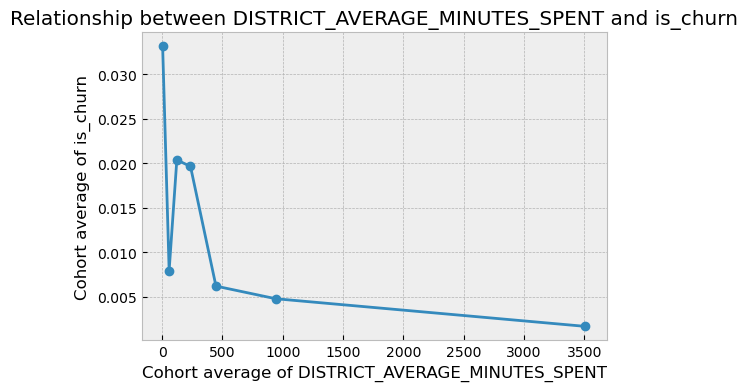

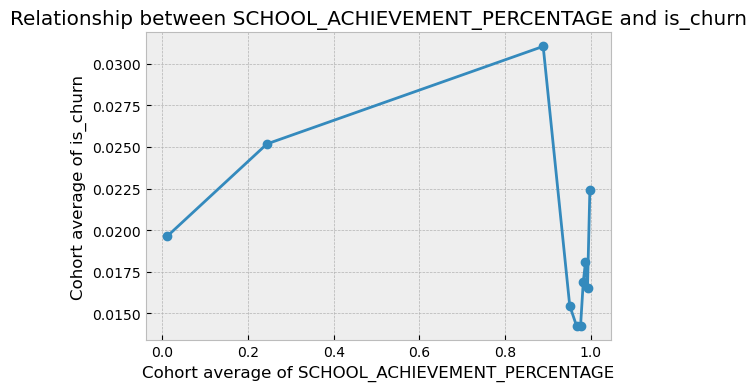

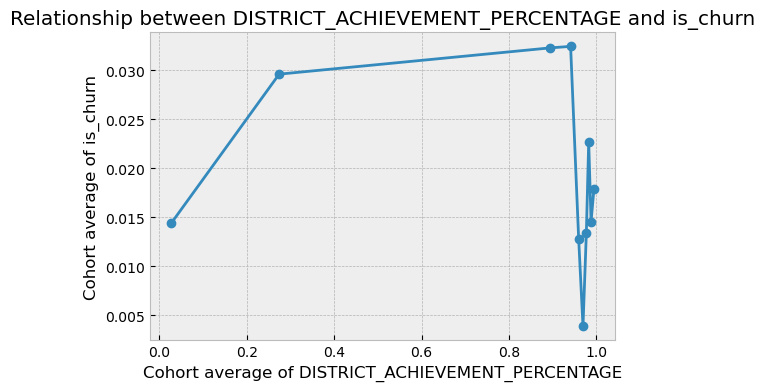

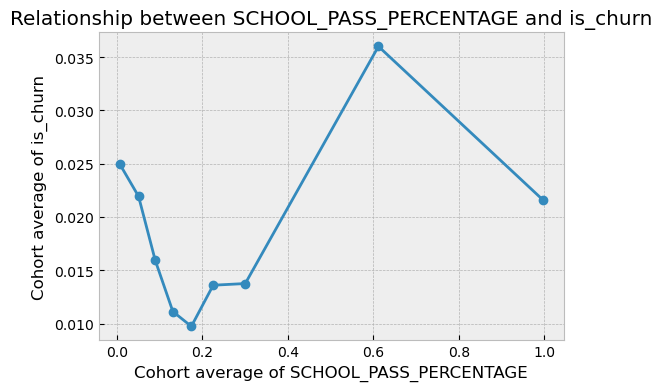

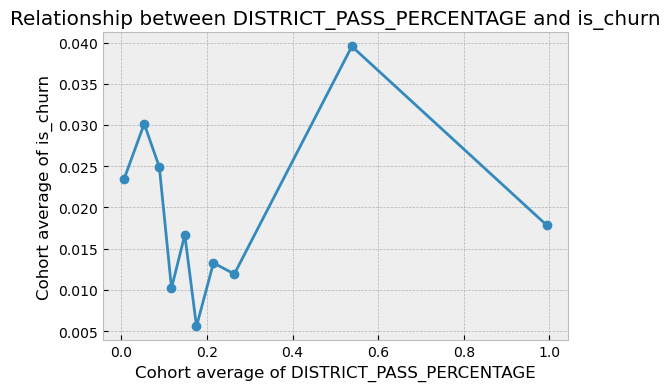

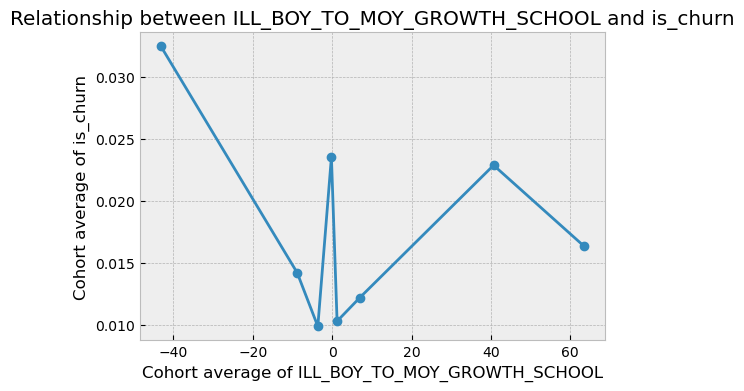

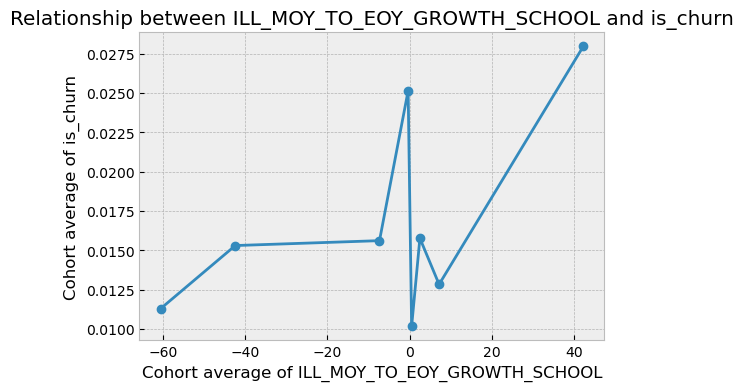

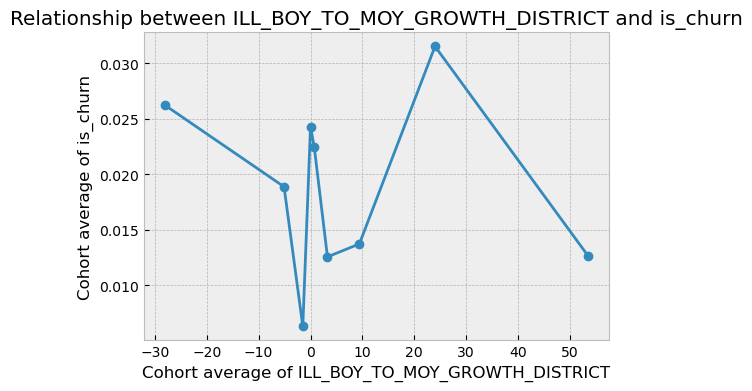

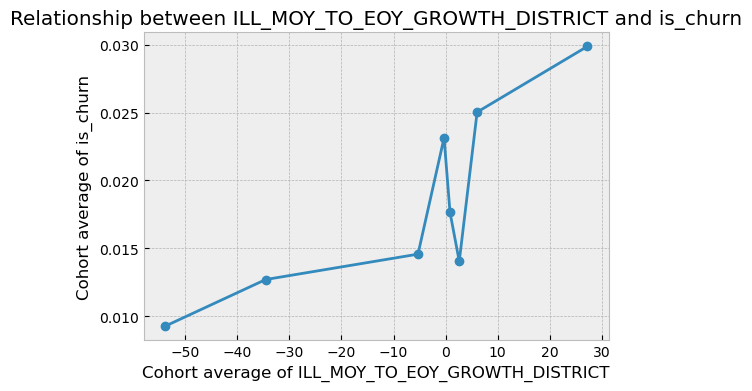

In [43]:
def cohort_plot(sourcedf, xmetric_name, ymetric_name, ncohort = 10, min_threshold = 5):
    # Cohorts are formed against xmetric and then means of each cohort is plotted for x and y metrics
    if len(sourcedf[xmetric_name].unique()) < min_threshold:
        cohort_xmeans = list(sourcedf[xmetric_name].unique())
        cohort_ymeans = sourcedf.groupby(xmetric_name)[ymetric_name].mean()
        df_to_plot = pd.DataFrame({xmetric_name: cohort_xmeans, ymetric_name: cohort_ymeans.values})
    else:
        groups = pd.qcut(sourcedf[xmetric_name], q=ncohort, duplicates = 'drop')
        cohort_xmeans = sourcedf.groupby(groups, observed=True)[xmetric_name].mean()
        cohort_ymeans = sourcedf.groupby(groups, observed=True)[ymetric_name].mean()
        df_to_plot = pd.DataFrame({xmetric_name: cohort_xmeans.values, ymetric_name: cohort_ymeans.values})
    
    plt.figure(figsize = (6,4))
    plt.plot(xmetric_name, ymetric_name, data = df_to_plot, marker = 'o', linewidth = 2)
    plt.xlabel('Cohort average of '+xmetric_name)
    plt.ylabel('Cohort average of '+ymetric_name)
    plt.grid(visible=True)
    plt.title("Relationship between "+xmetric_name+" and "+ymetric_name)


exclude_ = ['object'] # data type to exclude from the analysis
cols_ = []
for i in range(0, len(churn_metrics.dtypes), 1):
    if (str(churn_metrics.dtypes.iloc[i]) not in exclude_) & (churn_metrics.columns[i] != 'is_churn'):
        cols_.append(churn_metrics.columns[i])

for col in cols_:
    cohort_plot(churn_metrics, col, 'is_churn', 10, 5)

## DATA SPLIT

In [44]:
from sklearn.model_selection import train_test_split
churn_metrics['beginning_of_schoolyear'] = churn_metrics['SCHOOL_YEAR'].str.extract(r'(\d{4})').astype(int)

churn_metrics.sort_values(by = 'beginning_of_schoolyear', ascending = True, inplace = True)
churn_metrics.reset_index(inplace = True, drop = True)
churn_metrics.drop('beginning_of_schoolyear', axis=1, inplace = True)

# Prepare features and target labels
X = np.array(churn_metrics.drop(['SCHOOL_YEAR', 'is_churn'], axis=1))
y = np.array(churn_metrics['is_churn'])

# Prepare dataset and split it into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Time series split
tscv = TimeSeriesSplit(n_splits = 3)

## LOGISTIC REGRESSION

In [45]:
# Hyperparam selection
base_model = LogisticRegression(solver = 'liblinear')
test_par = {'C': [.005, .01, .04, .08, .16, .32, .64, .75, .95],
            'penalty' : ['l1','l2']          
           }
LR_gsearch = GridSearchCV(base_model, param_grid = test_par, scoring = 'roc_auc', cv = tscv, verbose = 1, n_jobs = -1)
LR_gsearch.fit(X_train,y_train)
LR_result_df = pd.DataFrame(LR_gsearch.cv_results_)

print(LR_gsearch.best_score_)
print(LR_gsearch.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/home/anjiang/anaconda3/envs/churn/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anjiang/anaconda3/envs/churn/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anjiang/anaconda3/envs/churn/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anjiang/anaconda3/envs/churn/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anjiang/anaconda3/envs/churn/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/anjiang/anaconda3/envs/churn/

0.7000754105041317
{'C': 0.16, 'penalty': 'l1'}


## RANDOM FOREST

Fitting 3 folds for each of 30 candidates, totalling 90 fits
0.9245289660527239
{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 1000}


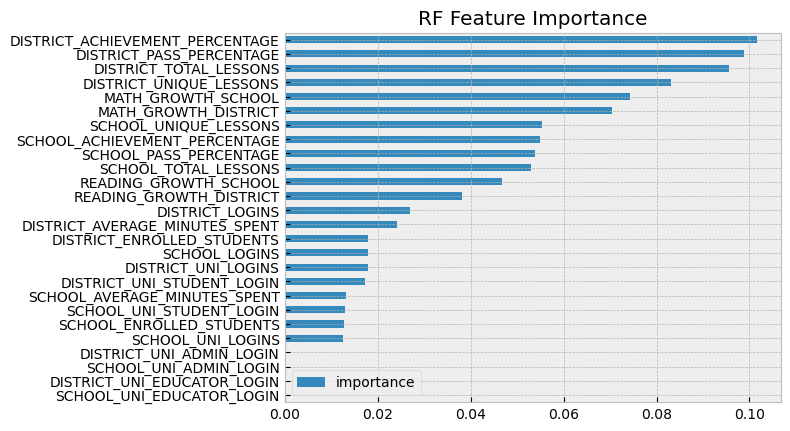

In [46]:
# Hyperparam selection
base_model = RandomForestClassifier(n_jobs = -1)
test_par = {'max_depth' : [2,5,10],
            'max_features': ['sqrt', 'log2'],
            'n_estimators': [5,10,100,500,1000]}
RF_gsearch = GridSearchCV(base_model, param_grid = test_par, scoring = 'roc_auc', cv=tscv, verbose=1, n_jobs=-1, refit=True)
RF_gsearch.fit(X_train,y_train)
RF_result_df = pd.DataFrame(RF_gsearch.cv_results_)

print(RF_gsearch.best_score_)
print(RF_gsearch.best_params_)

# Check feature importance
col_list = ['SCHOOL_ENROLLED_STUDENTS','DISTRICT_ENROLLED_STUDENTS','SCHOOL_LOGINS','DISTRICT_LOGINS','SCHOOL_UNI_LOGINS', 'DISTRICT_UNI_LOGINS', 'SCHOOL_UNI_STUDENT_LOGIN','DISTRICT_UNI_STUDENT_LOGIN', 'SCHOOL_UNI_EDUCATOR_LOGIN', 'DISTRICT_UNI_EDUCATOR_LOGIN', 'SCHOOL_UNI_ADMIN_LOGIN', 'DISTRICT_UNI_ADMIN_LOGIN', 'SCHOOL_TOTAL_LESSONS', 'SCHOOL_UNIQUE_LESSONS', 'DISTRICT_TOTAL_LESSONS', 'DISTRICT_UNIQUE_LESSONS', 'SCHOOL_AVERAGE_MINUTES_SPENT', 'DISTRICT_AVERAGE_MINUTES_SPENT', 'SCHOOL_ACHIEVEMENT_PERCENTAGE', 'DISTRICT_ACHIEVEMENT_PERCENTAGE', 'SCHOOL_PASS_PERCENTAGE', 'DISTRICT_PASS_PERCENTAGE', 'READING_GROWTH_SCHOOL', 'READING_GROWTH_DISTRICT', 'MATH_GROWTH_SCHOOL', 'MATH_GROWTH_DISTRICT']
X_feature = col_list
RF_feat = pd.DataFrame(data = RF_gsearch.best_estimator_.feature_importances_, index = X_feature, columns=['importance'])
RF_feat.sort_values('importance').plot(kind='barh', title = 'RF Feature Importance')
plt.show()

## XGBOOST

Fitting 3 folds for each of 300 candidates, totalling 900 fits
0.9284675384261026
{'learning_rate': 0.2, 'max_depth': 25, 'min_child_weight': 0.15, 'n_estimators': 50}


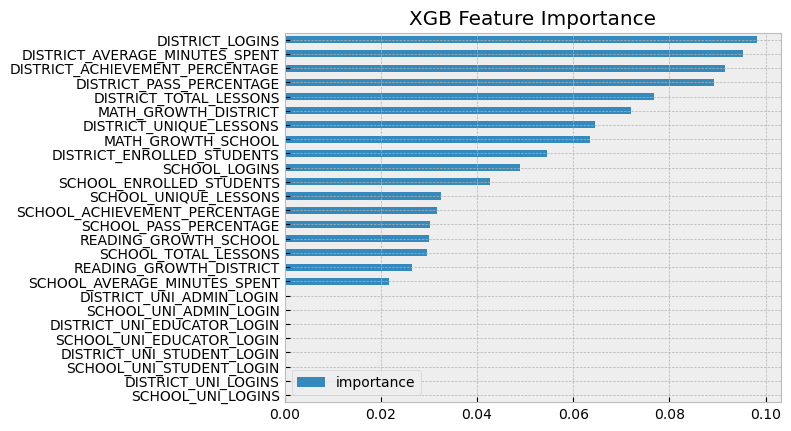

In [47]:
# Hyperparam selection
base_model = xgb.XGBClassifier(objective='binary:logistic', n_jobs = -1, eval_metric = 'auc')
test_par = {'max_depth' : [2,10,20,25,40],
            'learning_rate': [.1,.2,.5],
            'n_estimators': [5,10,20,30,50],
            'min_child_weight': [.05,.15,.5,1]}
XGB_gsearch = GridSearchCV(base_model, param_grid = test_par, scoring = 'roc_auc', cv=tscv, verbose=1, n_jobs=-1, refit=True)
XGB_gsearch.fit(X_train,y_train)
XGB_result_df = pd.DataFrame(XGB_gsearch.cv_results_)

print(XGB_gsearch.best_score_)
print(XGB_gsearch.best_params_)

# Check feature importance
X_feature = col_list
RF_feat = pd.DataFrame(data = XGB_gsearch.best_estimator_.feature_importances_, index = X_feature, columns=['importance'])
RF_feat.sort_values('importance').plot(kind='barh', title = 'XGB Feature Importance')
plt.show()

## TEST SET

In [48]:
print(X_test.shape)
print(y_test.shape)

(12944, 26)
(12944,)


## MODEL PREDICTIONS

0.9553002529456966


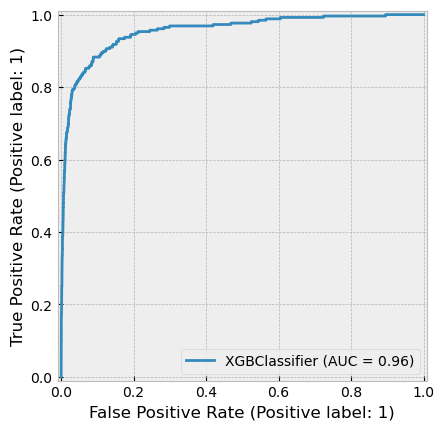

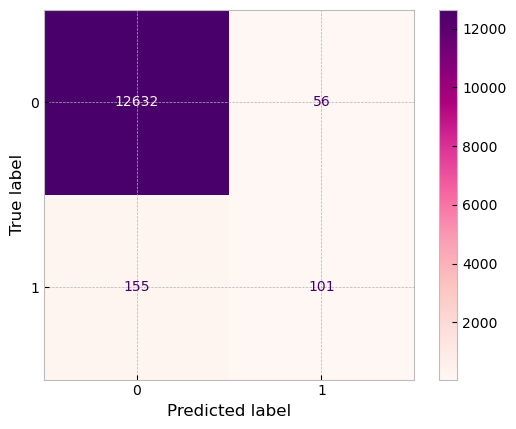

In [49]:
y_test_pred = XGB_gsearch.best_estimator_.predict_proba(X_test)[:,1]
print(metrics.roc_auc_score(y_test,y_test_pred))

metrics.RocCurveDisplay.from_estimator(XGB_gsearch.best_estimator_, X_test, y_test)
plt.show()

predicted_class = []
threshold = .5
for item in y_test_pred:
    if item >= threshold:
        predicted_class.append(1)
    else:
        predicted_class.append(0)
        
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predicted_class, labels=XGB_gsearch.best_estimator_.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=XGB_gsearch.best_estimator_.classes_)
cm_display.plot(cmap='RdPu')
# print(test_set.sort_values(by=['Predicted Churn Proba','is_churn'], ascending = False).head(5))


plt.style.use('bmh')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.float_Format', '{:,.2f}'.format)
np.set_printoptions(suppress=True)

## SHAP (SHapley Additive exPlanations)

In [54]:
import shap

Use the shap library to explain model predictions:

In [55]:
explainer = shap.TreeExplainer(XGB_gsearch.best_estimator_)
shap_values = explainer.shap_values(X_test)

Visualize Shapley values:

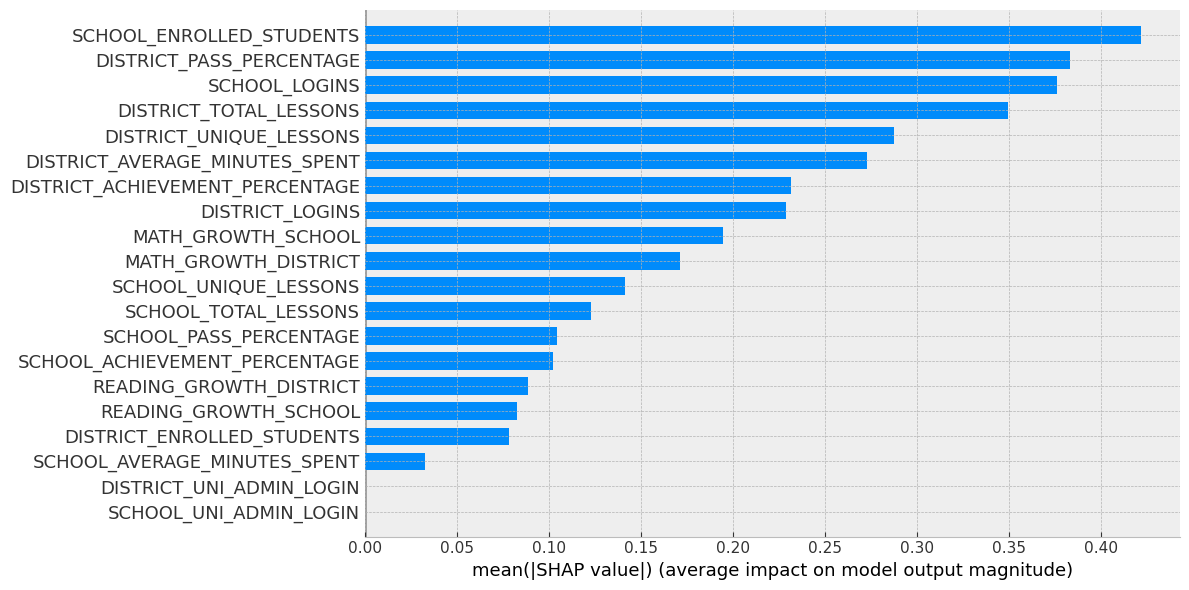

In [57]:
# Visualize Shapley values
shap.summary_plot(shap_values, X_test, feature_names=X_feature, plot_type='bar', plot_size=[12,6])